<hr/>

# imports

In [1]:
!pip install imblearn


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # mute tf warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import tensorflow as tf
from tensorflow import keras
from transformers import BertTokenizer, TFBertModel
import math
import sklearn
import imblearn

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


# Definitions

In [4]:
def pipe(*funcs):
    """
    Works similar to the semantics of a `pipe` in other programming languages.
    Intended to make nested functions readable and easier to manipulate. It 
    will take the first item in the list and feed it as input to the next
    function in the list, then it takes that output and feeds it as input to 
    the next function in the list, and so on until it reaches the last
    function in the list and returns its output.

    Example:
        instead of this:
            ```py
            input_layer = Input(...)
            embedding_layer = Embedding(...)(input_layer)
            lstm_layer = LSTM(...)(embedding_layer)
            hidden_layer = Dense(...)(lstm_layer)
            output_layer = Dense(...)(hidden_layer)
            ```
        you can do this:
            ```py
            lstm_ouput = pipe(
                Input(...),
                Embedding(...),
                LSTM(...),
                Dense(...),
                Dense(...)
            )
            ```
    """
    out = funcs[0]
    for func in funcs[1:]:
        out = func(out)
    return out

In [5]:
def determine_name(row) -> str:
    """
    Auxilary function used to determine the label for each given row.
    """
    if row['sender_labels'] and row['receiver_labels']:
        return 'straightforward'
    elif not row['sender_labels'] and row['receiver_labels']:
        return 'deceive'
    elif row['sender_labels'] and not row['receiver_labels']:
        return 'cassandra'
    elif not row['sender_labels'] and not row['receiver_labels']:
        return 'caught'
    else:
        return None

In [6]:
def parse_jsonl(path: str) -> pd.DataFrame:
    """
    Load the given jsonl file and parse each conversation into a readable pandas
    data frame, where each row is a message. Additional data that is used later
    is also added to the created dataframe for consistency accross all loaded
    data.

    Args:
        path: str
            the path to the jsonl file to load and parse
    
    Returns: pd.DataFrame
        A parsed data frame where each row is a message.
    """
    data = {}
    with open(path, 'r') as f:
        for (i, line) in enumerate(f):
            line = json.loads(line)
            line["conversation_id"] = [i] * len(line["messages"])
            line['previous_message'] = ([""] if len(line['messages']) > 0 else []) + line["messages"][:-1]
            for k in line.keys():
                if k == "players":
                    continue
                if k == "game_id":
                    line[k] = [line[k]] * len(line["messages"])
                data[k] = data.get(k, []) + line[k]
    data = pd.DataFrame(data)
    data['label'] = data.apply(determine_name, axis=1)
    data['sender_labels_encoded'] = data['sender_labels'].astype(str).apply(lambda x: ["True", "False", "NOANNOTATION"].index(x))
    data['receiver_labels_encoded'] = data['receiver_labels'].astype(str).apply(lambda x: ["True", "False", "NOANNOTATION"].index(x))
    data["game_score_delta"] = data['game_score_delta'].astype(float)
    return data

In [7]:
def EvaluateModel(model: tf.keras.Sequential, test_ds: tf.data.Dataset, test_target: pd.DataFrame, history: tf.keras.callbacks.History, skip_evaluation: bool = False) -> None:
    """
    Take the model and plot the training accuracy and validation accuracy. Also,
    Perform a evaluation on the test data, print the loss and accuracy, and print
    the test metric scores.

    Args:
        model: tf.keras.Sequential
            the model to test
        test_ds: tf.data.Dataset
            the test dataset to evaluate the model with
        test_target: pd.DataFrame
            the test data frame list with the target labels
        history: tf.keras.callbacks.History
            the history from fitting the model
        skip_evaluation: bool
            skip the model.evaluate() function
    """

    print(f"{'='*10} Model Accuracy {'='*10}")
    plt.plot(history.history['sender_output_accuracy'], label='sender_output_accuracy', color="tan")
    plt.plot(history.history['val_sender_output_accuracy'], label = 'val_sender_output_accuracy', color="darkorange")
    plt.plot(history.history['receiver_output_accuracy'], label='receiver_output_accuracy', color="cornflowerblue")
    plt.plot(history.history['val_receiver_output_accuracy'], label = 'val_receiver_output_accuracy', color="darkblue")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    plt.show()

    if not skip_evaluation:
        print(f"{'='*10} Test Evaluation {'='*10}")
        model.evaluate(test_ds, test_target, verbose=2)
        # print(f"Test loss: {test_loss} | Test accuracy: {test_acc}")
        print()

    print(f"{'='*10} Test Metrics {'='*10}")
    y_pred = model.predict(test_ds)
    print(f"{'-'*10} Sender Labels {'-'*10}")
    print(sklearn.metrics.classification_report(test_target[0], np.argmax(y_pred[0], axis=1), target_names=["True", "False"], zero_division=0))
    print(f"{'-'*10} Receiver Labels {'-'*10}")
    print(sklearn.metrics.classification_report(test_target[1], np.argmax(y_pred[1], axis=1), target_names=["True", "False"], zero_division=0))

In [8]:
def Tokenize(tokenizer, df: pd.DataFrame, sequence_len: int = 300) -> tuple:
    """
    Makes a consistant return of tokenized and padded messages and previous messages.
    """
    encoded_msg = tokenizer.texts_to_sequences(df['messages'])
    encoded_prev_msg = tokenizer.texts_to_sequences(df['previous_message'])
    return keras.preprocessing.sequence.pad_sequences(encoded_msg, sequence_len), keras.preprocessing.sequence.pad_sequences(encoded_prev_msg, sequence_len)

In [104]:
def PredictionGridPeek(pred: list, df: pd.DataFrame, target_labels: list, who: str) -> pd.DataFrame:
    table = {
        "prediction": [],
        "target": [],
        "message": [],
        "context": []
    }
    for match in [True, False]:
        bool_stmt = pred == df[f'{who}_labels_encoded'] if match else pred != df[f'{who}_labels_encoded']
        visited = []
        for i in range(0, len(pred)):
            row = df[bool_stmt].iloc[i,:]
            pred_label = target_labels[pred[bool_stmt][i]]
            if (pred_label, row[f'{who}_labels']) not in visited:
                table["prediction"].append(pred_label)
                table["target"].append(row[f'{who}_labels'])
                table['message'].append(row['messages'])
                table['context'].append(row['previous_message'])
                visited.append((pred_label, row[f'{who}_labels']))
                if len(visited) >= len(target_labels):
                    break
    return pd.DataFrame(table)

<hr/>

# data explortion

In [9]:
train_df = pd.read_json("./data/train.jsonl", lines=True)
train_df.head()

,messages,sender_labels,receiver_labels,speakers,receivers,absolute_message_index,relative_message_index,seasons,years,game_score,game_score_delta,players,game_id
0,[Germany!\n\nJust the person I want to speak w...,"[True, True, True, True, True, True, True, Tru...","[True, True, True, True, NOANNOTATION, NOANNOT...","[italy, germany, italy, germany, italy, italy,...","[germany, italy, germany, italy, germany, germ...","[74, 76, 86, 87, 89, 92, 97, 117, 119, 121, 12...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[italy, germany]",1
1,[Hello there! What's your general plan for thi...,"[True, False, True, False, True, True, True, T...","[True, True, True, True, True, NOANNOTATION, T...","[austria, italy, austria, italy, italy, austri...","[italy, austria, italy, austria, austria, ital...","[1, 67, 71, 73, 98, 99, 101, 179, 181, 185, 18...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 5, 4, 4, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, 1, -1, -...","[italy, austria]",1
2,[Buongiorno! \nBe kinda nice to know if you're...,"[True, True, False, True, True, True, True, Tr...","[True, False, True, False, True, True, NOANNOT...","[russia, italy, russia, italy, russia, italy, ...","[italy, russia, italy, russia, italy, russia, ...","[11, 50, 52, 57, 61, 66, 77, 85, 96, 102, 116,...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[4, 3, 4, 3, 4, 3, 4, 3, 3, 3, 4, 3, 3, 4, 4, ...","[1, -1, 1, -1, 1, -1, 1, -1, -1, -1, 1, -1, -1...","[italy, russia]",1
3,[Hey italy! good luck this game. I'm guessing ...,"[True, False, True, True, True, True, True, Tr...","[NOANNOTATION, True, True, False, True, True, ...","[england, italy, england, england, england, it...","[italy, england, italy, italy, italy, england,...","[32, 95, 106, 107, 108, 110, 113, 125, 126, 12...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Spring, Sprin...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[italy, england]",1
4,[Hello Italy what’s up what are your thoughts ...,"[True, False, False, True, True, True, True, T...","[NOANNOTATION, True, True, True, True, True, N...","[turkey, italy, italy, italy, turkey, italy, t...","[italy, turkey, turkey, turkey, italy, turkey,...","[45, 94, 103, 150, 154, 178, 192, 194, 195, 19...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[Spring, Spring, Spring, Spring, Fall, Fall, F...","[1901, 1901, 1901, 1901, 1901, 1901, 1901, 190...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 5, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, 1...","[italy, turkey]",1


just a raw load of the data we can see it is unformated and needs to be parsed a little to better satisfy the pandas format.

In [10]:
train_df = (parse_jsonl("./data/train.jsonl"))
test_df = (parse_jsonl("./data/test.jsonl"))
validation_df = (parse_jsonl("./data/validation.jsonl"))

In [11]:
train_df.head()

,messages,sender_labels,receiver_labels,speakers,receivers,absolute_message_index,relative_message_index,seasons,years,game_score,game_score_delta,game_id,conversation_id,previous_message,label,sender_labels_encoded,receiver_labels_encoded
0,Germany!\n\nJust the person I want to speak wi...,True,True,italy,germany,74,0,Spring,1901,3,0.0,1,0,,straightforward,0,0
1,"You've whet my appetite, Italy. What's the sug...",True,True,germany,italy,76,1,Spring,1901,3,0.0,1,0,Germany!\n\nJust the person I want to speak wi...,straightforward,0,0
2,👍,True,True,italy,germany,86,2,Spring,1901,3,0.0,1,0,"You've whet my appetite, Italy. What's the sug...",straightforward,0,0
3,It seems like there are a lot of ways that cou...,True,True,germany,italy,87,3,Spring,1901,3,0.0,1,0,👍,straightforward,0,0
4,"Yeah, I can’t say I’ve tried it and it works, ...",True,NOANNOTATION,italy,germany,89,4,Spring,1901,3,0.0,1,0,It seems like there are a lot of ways that cou...,straightforward,0,2


# NONANNOTATION

We can see that there are some `receiver_labels` that have the value `NOANNOTATION`. this is not a bool value 

In [12]:
round(len(train_df[train_df["receiver_labels"] == "NOANNOTATION"].index) /  len(train_df.index), 4) * 100

8.43

8.43% of the rows in `test_df` contain a "NOANNOTATION" `receiver_labels`.

In [47]:
train_df = train_df[train_df["receiver_labels"] != "NOANNOTATION"]
round(len(train_df[train_df["receiver_labels"] == "NOANNOTATION"].index) /  len(train_df.index), 4) * 100

0.0

`test_df` also contains some "NOANNOTATION" so we will remove them also.

In [48]:
test_df = test_df[test_df['receiver_labels'] != "NOANNOTATION"]
round(len(test_df[test_df["receiver_labels"] == "NOANNOTATION"].index) /  len(test_df.index), 4) * 100

0.0

# Unique Words

In [16]:
sequence_list = list(train_df['messages'].astype(str).str.lower().str.split().to_numpy())
unique_words = {}
for sequence in sequence_list:
    for word in sequence:
        unique_words[word] = unique_words.get(word, 0) + 1
    # sequence_list = sequence_list + (["<PAD>"] )

for (i,(k,v)) in enumerate(unique_words.items()):
    if i > 30:
        break
    print(f"{k}: {v}")

germany!: 11
just: 1146
the: 6037
person: 28
i: 8250
want: 779
to: 10653
speak: 17
with.: 34
have: 1944
a: 4399
somewhat: 15
crazy: 15
idea: 89
that: 3414
i’ve: 139
always: 75
wanted: 136
try: 284
with: 2364
i/g,: 1
but: 2086
never: 96
actually: 195
convinced: 11
other: 271
guy: 29
it.: 244
and,: 34
what’s: 73
worse,: 3


In [17]:
len(unique_words)

14991

<!-- I processed only what is considered a **word** to the regex `\w+`. this means that any punctuation is omitted. -->

After processing, we have a total of 15,657 words.

Some things to note are
- there are some arbitrary number included
- some words are repeated because of long character exaggeration (for example, "aaaaaalllllllllll" instead of "all" or "aaaaany" instead of "any")
- some words are repeated because of misspellings and typos

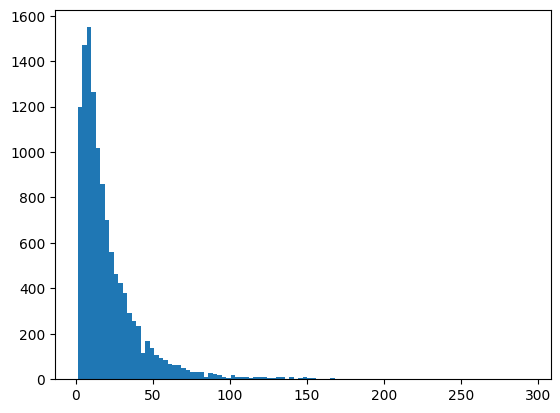

In [18]:
plt.hist(list(map(len, sequence_list)),bins=100)
plt.show()

In [19]:
summary = {
    "": [
        'Message count',
        'Average words per message',
        'Unique word count',
        'Actual Lie count',
        'Actual Truth count'
    ],
    "value": [
        len(train_df.index),
        math.floor(sum(map(len, sequence_list)) / len(sequence_list)),
        len(unique_words),
        (~train_df['sender_labels']).sum(),
        (train_df['sender_labels']).sum()
    ],
}
pd.DataFrame(summary)

,,value
0,Message count,12025
1,Average words per message,20
2,Unique word count,14991
3,Actual Lie count,545
4,Actual Truth count,11480


# Label count

In [20]:
train_df['label'].value_counts()

label
straightforward    10979
cassandra            501
deceive              480
caught                65
Name: count, dtype: int64

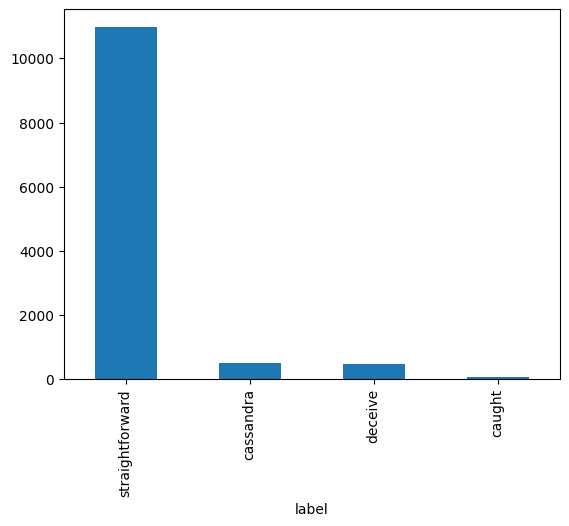

In [21]:
train_df['label'].value_counts().plot.bar()
plt.show()

In [22]:
train_df['label'].value_counts(normalize=True)

label
straightforward    0.913015
cassandra          0.041663
deceive            0.039917
caught             0.005405
Name: proportion, dtype: float64

<hr/>

# Constants

In [66]:
MAX_SEQUENCE_LEN = max(map(len,sequence_list))
VOCAB_SIZE = 5000 # len(unique_words)
EMBEDDING_OUTPUT_SIZE = 124
LSTM_SIZE = 64
DROPOUT_RATE = 0.2
HIDDEN_LAYER_SIZE = 64
LEARNING_RATE = 0.001

CLASS_LABELS = ["True", "False"]

tokenizer = keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df['messages'])
# smote = imblearn.over_sampling.SMOTE()

# train_encoded_padded, y_train = smote.fit_resample(train_tokenized_padded, train_df['label_encoded'])
# train_prev_encoded_padded, y_train = smote.fit_resample(train_prev_tokenized_padded, train_df['label_encoded'])

train_encoded_padded, train_prev_encoded_padded = Tokenize(tokenizer, train_df, MAX_SEQUENCE_LEN)
test_encoded_padded, test_prev_encoded_padded = Tokenize(tokenizer, test_df, MAX_SEQUENCE_LEN)
validation_encoded_padded, validation_prev_encoded_padded = Tokenize(tokenizer, validation_df, MAX_SEQUENCE_LEN)

<hr/>

# Naive Neural Network

In [24]:
def create_naive_model(
        vocab_size: int = VOCAB_SIZE,
        embedding_output: int = EMBEDDING_OUTPUT_SIZE,
        sequence_length: int = MAX_SEQUENCE_LEN,
        hidden_size: int = HIDDEN_LAYER_SIZE,
        learning_rate: float = LEARNING_RATE
    ):

    message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='message_input')
    
    naive_output = pipe(
        message_input,
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.Flatten(),
        keras.layers.Dense(hidden_size, activation="relu")
    )
        
    sender_output = keras.layers.Dense(2, activation='softmax', name="sender_output")(naive_output)
    receiver_output = keras.layers.Dense(2, activation='softmax', name="receiver_output")(naive_output)

    model = keras.Model(
        inputs=[message_input],
        outputs=[sender_output, receiver_output]
    )

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )

    return model

In [25]:
naive_model = create_naive_model()
naive_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 message_input (InputLayer)  [(None, 294)]                0         []                            
                                                                                                  
 embedding (Embedding)       (None, 294, 124)             620000    ['message_input[0][0]']       
                                                                                                  
 flatten (Flatten)           (None, 36456)                0         ['embedding[0][0]']           
                                                                                                  
 dense (Dense)               (None, 64)                   2333248   ['flatten[0][0]']             
                                                                                              

In [26]:
naive_history = naive_model.fit(
    train_encoded_padded,
    [train_df['sender_labels_encoded'], train_df['receiver_labels_encoded']],
    validation_data=(validation_encoded_padded, [validation_df['sender_labels_encoded'], validation_df['receiver_labels_encoded']]),
    epochs=10
)

Epoch 1/10
376/376 [==============================] - 23s 56ms/step - loss: 0.3849 - sender_output_loss: 0.1858 - receiver_output_loss: 0.1992 - sender_output_accuracy: 0.9548 - receiver_output_accuracy: 0.9528 - val_loss: nan - val_sender_output_loss: 0.1612 - val_receiver_output_loss: nan - val_sender_output_accuracy: 0.9605 - val_receiver_output_accuracy: 0.8729
Epoch 2/10
376/376 [==============================] - 7s 19ms/step - loss: 0.2914 - sender_output_loss: 0.1296 - receiver_output_loss: 0.1618 - sender_output_accuracy: 0.9604 - receiver_output_accuracy: 0.9534 - val_loss: nan - val_sender_output_loss: 0.1898 - val_receiver_output_loss: nan - val_sender_output_accuracy: 0.9590 - val_receiver_output_accuracy: 0.8729
Epoch 3/10
376/376 [==============================] - 5s 14ms/step - loss: 0.1509 - sender_output_loss: 0.0611 - receiver_output_loss: 0.0898 - sender_output_accuracy: 0.9809 - receiver_output_accuracy: 0.9698 - val_loss: nan - val_sender_output_loss: 0.2627 - val_

========== Model Accuracy ==========


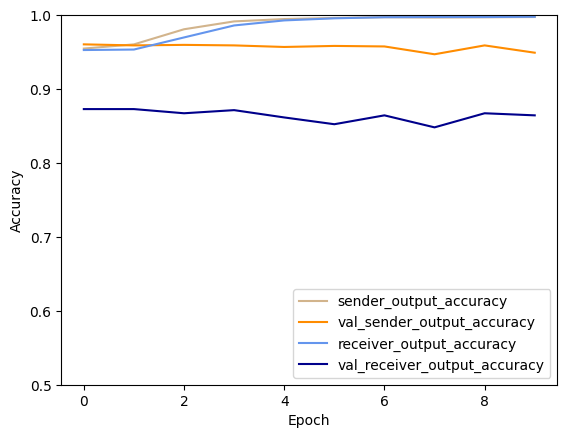

========== Test Evaluation ==========
78/78 - 0s - loss: 1.8012 - sender_output_loss: 1.0053 - receiver_output_loss: 0.7959 - sender_output_accuracy: 0.8962 - receiver_output_accuracy: 0.9240 - 312ms/epoch - 4ms/step

========== Test Metrics ==========
78/78 [==============================] - 0s 2ms/step
---------- Sender Labels ----------
              precision    recall  f1-score   support

        True       0.92      0.97      0.95      2268
       False       0.11      0.03      0.05       207

    accuracy                           0.90      2475
   macro avg       0.51      0.50      0.50      2475
weighted avg       0.85      0.90      0.87      2475

---------- Receiver Labels ----------
              precision    recall  f1-score   support

        True       0.93      0.99      0.96      2310
       False       0.10      0.02      0.03       165

    accuracy                           0.92      2475
   macro avg       0.52      0.50      0.50      2475
weighted avg       0.

In [27]:
EvaluateModel(naive_model, test_encoded_padded, [test_df['sender_labels_encoded'], test_df['receiver_labels_encoded']], naive_history)

# Naive LSTM

In [28]:
def create_naive_lstm_model(
        sequence_length: int = MAX_SEQUENCE_LEN,
        embedding_output: int = EMBEDDING_OUTPUT_SIZE,
        vocab_size: int = VOCAB_SIZE,
        lstm_size: int = LSTM_SIZE,
        hidden_size = HIDDEN_LAYER_SIZE,
        learning_rate: float = LEARNING_RATE,
    ):

    message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='message_input')

    naive_lstm_ouput = pipe(
        message_input,
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.LSTM(lstm_size),
        keras.layers.Dense(hidden_size),
    )

    sender_output = keras.layers.Dense(2, activation='softmax', name="sender_output")(naive_lstm_ouput)
    receiver_output = keras.layers.Dense(2, activation='softmax', name="receiver_output")(naive_lstm_ouput)

    model = keras.Model(
        inputs=[message_input],
        outputs=[sender_output, receiver_output]
    )

    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )

    return model

In [29]:
naive_lstm_model = create_naive_lstm_model()
naive_lstm_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 message_input (InputLayer)  [(None, 294)]                0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 294, 124)             620000    ['message_input[0][0]']       
                                                                                                  
 lstm (LSTM)                 (None, 64)                   48384     ['embedding_1[0][0]']         
                                                                                                  
 dense_1 (Dense)             (None, 64)                   4160      ['lstm[0][0]']                
                                                                                            

In [30]:
naive_lstm_history = naive_lstm_model.fit(
    train_encoded_padded,
    [train_df['sender_labels_encoded'], train_df['receiver_labels_encoded']],
    validation_data=(validation_encoded_padded, [validation_df['sender_labels_encoded'], validation_df['receiver_labels_encoded']]),
    epochs=10
)

Epoch 1/10
376/376 [==============================] - 24s 58ms/step - loss: 0.4012 - sender_output_loss: 0.1989 - receiver_output_loss: 0.2022 - sender_output_accuracy: 0.9535 - receiver_output_accuracy: 0.9519 - val_loss: nan - val_sender_output_loss: 0.1637 - val_receiver_output_loss: nan - val_sender_output_accuracy: 0.9605 - val_receiver_output_accuracy: 0.8729
Epoch 2/10
376/376 [==============================] - 12s 33ms/step - loss: 0.3449 - sender_output_loss: 0.1651 - receiver_output_loss: 0.1798 - sender_output_accuracy: 0.9549 - receiver_output_accuracy: 0.9531 - val_loss: nan - val_sender_output_loss: 0.1777 - val_receiver_output_loss: nan - val_sender_output_accuracy: 0.9605 - val_receiver_output_accuracy: 0.8729
Epoch 3/10
376/376 [==============================] - 11s 30ms/step - loss: 0.2819 - sender_output_loss: 0.1314 - receiver_output_loss: 0.1505 - sender_output_accuracy: 0.9583 - receiver_output_accuracy: 0.9533 - val_loss: nan - val_sender_output_loss: 0.2013 - va

========== Model Accuracy ==========


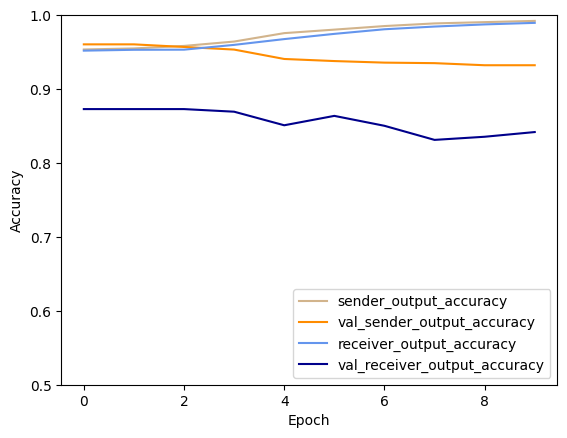

========== Test Evaluation ==========
78/78 - 1s - loss: 1.5916 - sender_output_loss: 0.9290 - receiver_output_loss: 0.6627 - sender_output_accuracy: 0.8958 - receiver_output_accuracy: 0.9067 - 935ms/epoch - 12ms/step

========== Test Metrics ==========
78/78 [==============================] - 1s 9ms/step
---------- Sender Labels ----------
              precision    recall  f1-score   support

        True       0.92      0.97      0.94      2268
       False       0.15      0.05      0.08       207

    accuracy                           0.90      2475
   macro avg       0.53      0.51      0.51      2475
weighted avg       0.85      0.90      0.87      2475

---------- Receiver Labels ----------
              precision    recall  f1-score   support

        True       0.93      0.97      0.95      2310
       False       0.09      0.04      0.06       165

    accuracy                           0.91      2475
   macro avg       0.51      0.51      0.50      2475
weighted avg       0

In [31]:
EvaluateModel(naive_lstm_model, test_encoded_padded, [test_df['sender_labels_encoded'], test_df['receiver_labels_encoded']], naive_lstm_history)

<hr/>

# Context lstm

In [32]:
def create_context_lstm_model(
        sequence_length: int = MAX_SEQUENCE_LEN,
        embedding_output: int = EMBEDDING_OUTPUT_SIZE,
        vocab_size: int = VOCAB_SIZE,
        lstm_size: int = LSTM_SIZE,
        dropout: float = DROPOUT_RATE,
        hidden_size = HIDDEN_LAYER_SIZE,
        learning_rate: float = LEARNING_RATE,
    ):

    current_message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='current_message_input')
    previous_message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='previous_message_input')

    current_message_lstm = pipe(
        current_message_input,
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.LSTM(lstm_size),
        keras.layers.Dropout(dropout)
    )

    previous_message_lstm = pipe(
        previous_message_input,
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.LSTM(lstm_size),
        keras.layers.Dropout(dropout)
    )

    context_lstm_ouput = pipe(
        [
            current_message_lstm,
            previous_message_lstm
        ],
        keras.layers.Concatenate(),
        keras.layers.Dense(hidden_size)
    )

    sender_output = keras.layers.Dense(2, activation='softmax', name="sender_output")(context_lstm_ouput)
    receiver_output = keras.layers.Dense(2, activation='softmax', name="receiver_output")(context_lstm_ouput)

    context_lstm_model = keras.Model(
        inputs=[current_message_input, previous_message_input],
        outputs=[sender_output, receiver_output]
    )

    context_lstm_model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )

    return context_lstm_model

In [33]:
context_lstm_model = create_context_lstm_model()
context_lstm_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 current_message_input (Inp  [(None, 294)]                0         []                            
 utLayer)                                                                                         
                                                                                                  
 previous_message_input (In  [(None, 294)]                0         []                            
 putLayer)                                                                                        
                                                                                                  
 embedding_2 (Embedding)     (None, 294, 124)             620000    ['current_message_input[0][0]'
                                                                    ]                       

In [34]:
context_lstm_history = context_lstm_model.fit(
    [train_encoded_padded, train_prev_encoded_padded],
    [train_df['sender_labels_encoded'], train_df['receiver_labels_encoded']], 
    validation_data=([validation_encoded_padded, validation_prev_encoded_padded], [validation_df['sender_labels_encoded'], validation_df['receiver_labels_encoded']]), 
    epochs=10
)

Epoch 1/10
376/376 [==============================] - 38s 88ms/step - loss: 0.4074 - sender_output_loss: 0.1996 - receiver_output_loss: 0.2078 - sender_output_accuracy: 0.9528 - receiver_output_accuracy: 0.9522 - val_loss: nan - val_sender_output_loss: 0.1633 - val_receiver_output_loss: nan - val_sender_output_accuracy: 0.9605 - val_receiver_output_accuracy: 0.8729
Epoch 2/10
376/376 [==============================] - 20s 52ms/step - loss: 0.3188 - sender_output_loss: 0.1512 - receiver_output_loss: 0.1676 - sender_output_accuracy: 0.9558 - receiver_output_accuracy: 0.9529 - val_loss: nan - val_sender_output_loss: 0.1821 - val_receiver_output_loss: nan - val_sender_output_accuracy: 0.9605 - val_receiver_output_accuracy: 0.8729
Epoch 3/10
376/376 [==============================] - 19s 51ms/step - loss: 0.2131 - sender_output_loss: 0.0965 - receiver_output_loss: 0.1166 - sender_output_accuracy: 0.9656 - receiver_output_accuracy: 0.9598 - val_loss: nan - val_sender_output_loss: 0.2715 - va

========== Model Accuracy ==========


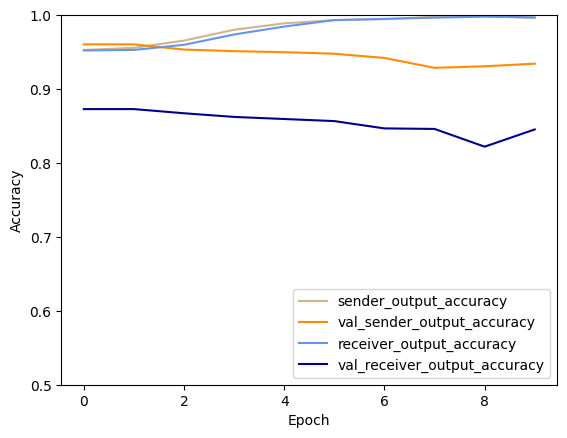

========== Test Evaluation ==========
78/78 - 1s - loss: 2.3895 - sender_output_loss: 1.2362 - receiver_output_loss: 1.1533 - sender_output_accuracy: 0.8933 - receiver_output_accuracy: 0.9139 - 1s/epoch - 19ms/step

========== Test Metrics ==========
78/78 [==============================] - 2s 18ms/step
---------- Sender Labels ----------
              precision    recall  f1-score   support

        True       0.92      0.97      0.94      2268
       False       0.17      0.07      0.10       207

    accuracy                           0.89      2475
   macro avg       0.55      0.52      0.52      2475
weighted avg       0.86      0.89      0.87      2475

---------- Receiver Labels ----------
              precision    recall  f1-score   support

        True       0.94      0.97      0.95      2310
       False       0.16      0.07      0.09       165

    accuracy                           0.91      2475
   macro avg       0.55      0.52      0.52      2475
weighted avg       0.8

In [35]:
EvaluateModel(context_lstm_model, [test_encoded_padded, test_prev_encoded_padded], [test_df['sender_labels_encoded'], test_df['receiver_labels_encoded']], context_lstm_history)

# LSTM + Power

In [36]:
def create_lstm_power_model(
        sequence_length: int = MAX_SEQUENCE_LEN,
        embedding_output: int = EMBEDDING_OUTPUT_SIZE,
        vocab_size: int = VOCAB_SIZE,
        lstm_size: int = LSTM_SIZE,
        dropout: float = DROPOUT_RATE,
        hidden_size = HIDDEN_LAYER_SIZE,
        learning_rate: float = LEARNING_RATE,
    ):

    message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='current_message_input')
    power_diff_input = keras.layers.Input(shape=(1,), name='power_differential')

    lstm_output = pipe(
        message_input,
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.LSTM(lstm_size),
        keras.layers.Dropout(dropout)
    )

    lstm_power_ouput = pipe(
        [
            lstm_output,
            power_diff_input
        ],
        keras.layers.Concatenate(),
        keras.layers.Dense(hidden_size),
    )

    sender_output = keras.layers.Dense(2, activation='softmax', name="sender_output")(lstm_power_ouput)
    receiver_output = keras.layers.Dense(2, activation='softmax', name="receiver_output")(lstm_power_ouput)

    lstm_power_model = keras.Model(
        inputs=[message_input, power_diff_input],
        outputs=[sender_output, receiver_output]
    )

    lstm_power_model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )

    return lstm_power_model

In [37]:
lstm_power_model = create_lstm_power_model()
lstm_power_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 current_message_input (Inp  [(None, 294)]                0         []                            
 utLayer)                                                                                         
                                                                                                  
 embedding_4 (Embedding)     (None, 294, 124)             620000    ['current_message_input[0][0]'
                                                                    ]                             
                                                                                                  
 lstm_3 (LSTM)               (None, 64)                   48384     ['embedding_4[0][0]']         
                                                                                            

In [38]:
lstm_power_history = context_lstm_model.fit(
    [train_encoded_padded, train_df['game_score_delta']],
    [train_df['sender_labels_encoded'], train_df['receiver_labels_encoded']],
    validation_data=([validation_encoded_padded, validation_df['game_score_delta']], [validation_df['sender_labels_encoded'], validation_df['receiver_labels_encoded']]), 
    epochs=10
)

Epoch 1/10
376/376 [==============================] - 16s 36ms/step - loss: 0.1847 - sender_output_loss: 0.0807 - receiver_output_loss: 0.1040 - sender_output_accuracy: 0.9719 - receiver_output_accuracy: 0.9635 - val_loss: nan - val_sender_output_loss: 0.3052 - val_receiver_output_loss: nan - val_sender_output_accuracy: 0.9506 - val_receiver_output_accuracy: 0.8686
Epoch 2/10
376/376 [==============================] - 12s 31ms/step - loss: 0.1029 - sender_output_loss: 0.0439 - receiver_output_loss: 0.0590 - sender_output_accuracy: 0.9854 - receiver_output_accuracy: 0.9793 - val_loss: nan - val_sender_output_loss: 0.3630 - val_receiver_output_loss: nan - val_sender_output_accuracy: 0.9477 - val_receiver_output_accuracy: 0.8545
Epoch 3/10
376/376 [==============================] - 12s 31ms/step - loss: 0.0757 - sender_output_loss: 0.0322 - receiver_output_loss: 0.0435 - sender_output_accuracy: 0.9895 - receiver_output_accuracy: 0.9863 - val_loss: nan - val_sender_output_loss: 0.4937 - va

========== Model Accuracy ==========


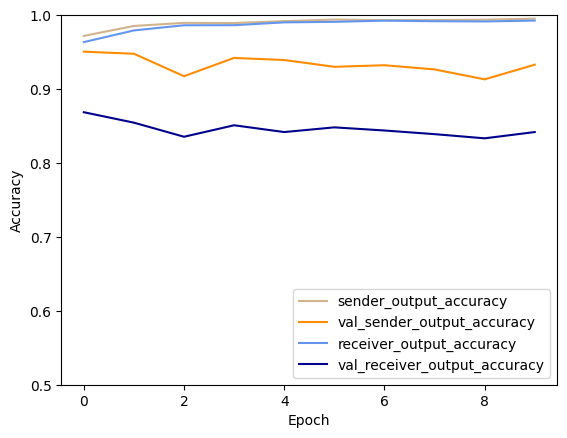

========== Test Evaluation ==========
78/78 - 2s - loss: 1.4621 - sender_output_loss: 0.7207 - receiver_output_loss: 0.7414 - sender_output_accuracy: 0.5507 - receiver_output_accuracy: 0.5204 - 2s/epoch - 30ms/step

========== Test Metrics ==========
78/78 [==============================] - 1s 8ms/step
---------- Sender Labels ----------
              precision    recall  f1-score   support

        True       0.93      0.55      0.69      2268
       False       0.10      0.53      0.16       207

    accuracy                           0.55      2475
   macro avg       0.51      0.54      0.43      2475
weighted avg       0.86      0.55      0.65      2475

---------- Receiver Labels ----------
              precision    recall  f1-score   support

        True       0.92      0.53      0.67      2310
       False       0.05      0.38      0.09       165

    accuracy                           0.52      2475
   macro avg       0.49      0.45      0.38      2475
weighted avg       0.86

In [39]:
EvaluateModel(lstm_power_model, [test_encoded_padded, test_df['game_score_delta']], [test_df['sender_labels_encoded'], test_df['receiver_labels_encoded']], lstm_power_history)

# Context LSTM + Power

In [40]:
def create_context_lstm_power_model(
        sequence_length: int = MAX_SEQUENCE_LEN,
        embedding_output: int = EMBEDDING_OUTPUT_SIZE,
        vocab_size: int = VOCAB_SIZE,
        lstm_size: int = LSTM_SIZE,
        dropout: float = DROPOUT_RATE,
        hidden_size = HIDDEN_LAYER_SIZE,
        learning_rate: float = LEARNING_RATE,
    ):

    current_message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='current_message_input')
    previous_message_input = keras.layers.Input(shape=(sequence_length,), dtype=tf.int64, name='previous_message_input')
    power_diff_input = keras.layers.Input(shape=(1,), name='power_differential')

    current_message_lstm = pipe(
        current_message_input,
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.LSTM(lstm_size),
        keras.layers.Dropout(dropout)
    )

    previous_message_lstm = pipe(
        previous_message_input,
        keras.layers.Embedding(vocab_size, embedding_output, input_length=sequence_length),
        keras.layers.LSTM(lstm_size),
        keras.layers.Dropout(dropout)
    )

    context_lstm_power_ouput = pipe(
        [
            current_message_lstm,
            previous_message_lstm,
            power_diff_input
        ],
        keras.layers.Concatenate(),
        keras.layers.Dense(hidden_size)
    )

    sender_output = keras.layers.Dense(2, activation='softmax', name="sender_output")(context_lstm_power_ouput)
    receiver_output = keras.layers.Dense(2, activation='softmax', name="receiver_output")(context_lstm_power_ouput)

    context_lstm_power_model = keras.Model(
        inputs=[current_message_input, previous_message_input, power_diff_input],
        outputs=[sender_output, receiver_output]
    )

    context_lstm_power_model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )

    return context_lstm_power_model

In [41]:
context_lstm_power_model = create_context_lstm_power_model()
context_lstm_power_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 current_message_input (Inp  [(None, 294)]                0         []                            
 utLayer)                                                                                         
                                                                                                  
 previous_message_input (In  [(None, 294)]                0         []                            
 putLayer)                                                                                        
                                                                                                  
 embedding_5 (Embedding)     (None, 294, 124)             620000    ['current_message_input[0][0]'
                                                                    ]                       

In [42]:
context_lstm_power_history = context_lstm_power_model.fit(
    [train_encoded_padded, train_prev_encoded_padded, train_df['game_score_delta']],
    [train_df['sender_labels_encoded'], train_df['receiver_labels_encoded']],
    validation_data=([validation_encoded_padded, validation_prev_encoded_padded, validation_df['game_score_delta']], [validation_df['sender_labels_encoded'], validation_df['receiver_labels_encoded']]), 
    epochs=10
)

Epoch 1/10
376/376 [==============================] - 36s 85ms/step - loss: 0.3929 - sender_output_loss: 0.1887 - receiver_output_loss: 0.2041 - sender_output_accuracy: 0.9518 - receiver_output_accuracy: 0.9484 - val_loss: nan - val_sender_output_loss: 0.1656 - val_receiver_output_loss: nan - val_sender_output_accuracy: 0.9605 - val_receiver_output_accuracy: 0.8729
Epoch 2/10
376/376 [==============================] - 20s 53ms/step - loss: 0.3135 - sender_output_loss: 0.1480 - receiver_output_loss: 0.1655 - sender_output_accuracy: 0.9557 - receiver_output_accuracy: 0.9525 - val_loss: nan - val_sender_output_loss: 0.2028 - val_receiver_output_loss: nan - val_sender_output_accuracy: 0.9555 - val_receiver_output_accuracy: 0.8715
Epoch 3/10
376/376 [==============================] - 19s 51ms/step - loss: 0.2151 - sender_output_loss: 0.0959 - receiver_output_loss: 0.1192 - sender_output_accuracy: 0.9657 - receiver_output_accuracy: 0.9571 - val_loss: nan - val_sender_output_loss: 0.2524 - va

========== Model Accuracy ==========


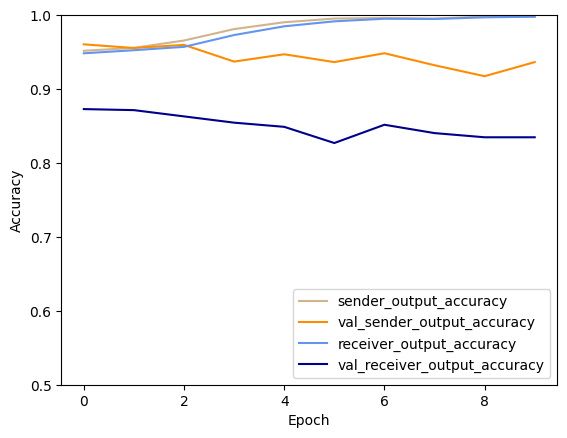

========== Test Evaluation ==========
78/78 - 1s - loss: 2.7562 - sender_output_loss: 1.5392 - receiver_output_loss: 1.2170 - sender_output_accuracy: 0.9022 - receiver_output_accuracy: 0.9006 - 1s/epoch - 19ms/step

========== Test Metrics ==========
78/78 [==============================] - 2s 19ms/step
---------- Sender Labels ----------
              precision    recall  f1-score   support

        True       0.92      0.98      0.95      2268
       False       0.21      0.06      0.10       207

    accuracy                           0.90      2475
   macro avg       0.57      0.52      0.52      2475
weighted avg       0.86      0.90      0.88      2475

---------- Receiver Labels ----------
              precision    recall  f1-score   support

        True       0.94      0.96      0.95      2310
       False       0.11      0.07      0.08       165

    accuracy                           0.90      2475
   macro avg       0.52      0.51      0.51      2475
weighted avg       0.8

In [43]:
EvaluateModel(context_lstm_power_model, [test_encoded_padded, test_prev_encoded_padded, test_df['game_score_delta']], [test_df['sender_labels_encoded'], test_df['receiver_labels_encoded']], context_lstm_power_history)

<hr/>

# Context LSTM Prediction Analysis

In [45]:
pred = context_lstm_model.predict([test_encoded_padded, test_prev_encoded_padded])
sender_pred = np.argmax(pred[0], axis=1)
receiver_pred = np.argmax(pred[1], axis=1)

display(sender_pred)
display(receiver_pred)

78/78 [==============================] - 2s 24ms/step


array([0, 0, 0, ..., 0, 0, 0])

array([1, 0, 0, ..., 0, 0, 0])

## Sender Predictions

In [109]:
sender_table = PredictionGridPeek(sender_pred, test_df, CLASS_LABELS, "sender")
sender_table

,prediction,target,message,context
0,True,True,"Hi Italy! Just opening up communication, and I...",
1,False,False,I don't see why you need a dot,Alright I'll think about the move set and get ...
2,True,False,"I'd personally rather you didn't, because a pl...","Bongiorno! To crush my enemies, see them driv..."
3,False,True,"Hello Italy, just wanted to thank you for your...",


In [113]:
sender_table["message"].map(display);

'Hi Italy! Just opening up communication, and I want to know what some of your initial thoughts on the game are and if/how we can work together'

"I don't see why you need a dot"

"I'd personally rather you didn't, because a play around Munich is also a play around Trieste and Vienna. I've heard that there's some rancor over in the West and you might be able to profit from a mobbed France if you went that way."

'Hello Italy, just wanted to thank you for your gift to the culinary world and wish you a good game!'

In [114]:
sender_table["context"].map(display);

''

"Alright I'll think about the move set and get back to you in the morning"

'Bongiorno!  To crush my enemies, see them driven before me, and hear the lamentations of their women!  I mean, umm, not really sure yet.  Pondering whether or not to make an early play around Munich'

''

## Receiver Predictions

In [115]:
receiver_table = PredictionGridPeek(receiver_pred, test_df, CLASS_LABELS, "receiver")
receiver_table

,prediction,target,message,context
0,True,True,"Well....that's a great question, and a lot of ...","Hi Italy! Just opening up communication, and I..."
1,False,False,I think we should leave the Black Sea as a DMZ...,Hi Turkey! I would love to have a good relatio...
2,False,True,"Hi Italy! Just opening up communication, and I...",
3,True,False,"Well, if you want to attack France in the Medi...","Well....that's a great question, and a lot of ..."


In [116]:
receiver_table["message"].map(display);

"Well....that's a great question, and a lot of it comes down to how free I'll be left to play in the West, no?"

"I think we should leave the Black Sea as a DMZ, as I would like to 100% ensure I get Rum and I'm worried about Austria taking it. So if we can agree to leave it as a DMZ I can move my fleet to rum"

'Hi Italy! Just opening up communication, and I want to know what some of your initial thoughts on the game are and if/how we can work together'

'Well, if you want to attack France in the Mediterranean while I attack through Burgundy you can have Marseille and Iberia while I take Brest and Paris, then with France out of the way you could focus on Turkey or Austria. Sound fair?'

In [117]:
receiver_table["context"].map(display);

'Hi Italy! Just opening up communication, and I want to know what some of your initial thoughts on the game are and if/how we can work together'

'Hi Turkey! I would love to have a good relationship between our two great countries! Are you up for blitzing Austria? Looking forwards to a great game with you! \n-Russia'

''

"Well....that's a great question, and a lot of it comes down to how free I'll be left to play in the West, no?"